In [5]:
import numpy as np
from qiskit.circuit import QuantumCircuit, ParameterVector
import random
import math, torch
import torch.nn as nn
import torch.optim as optim

SEED = 40
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.bool8 = np.bool_
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sub-block : single qubit rotation layer (Rz, Ry, Rx)
def one_qubit_rotation(qc: QuantumCircuit, qubit: int, thetas) : 
    qc.rz(thetas[0], qubit)
    qc.ry(thetas[1], qubit)
    qc.rx(thetas[2], qubit)
    
# sub-block : entangling layer (linear)
def entangling_layer(qc: QuantumCircuit, qubits) : 
    for control, target in zip(qubits, qubits[1:]) : 
        qc.cx(control, target)

    qc.cx(len(qubits) - 1, 0)

# main circuit-generating function
def generate_circuit(n_qubits: int, n_layers: int) : 
    theta = ParameterVector('theta', (n_layers + 1) * n_qubits * 3)
    theta = np.asarray(theta).reshape((n_layers + 1, n_qubits, 3))

    x = ParameterVector('x', n_layers * n_qubits)
    x = np.asarray(x).reshape((n_layers, n_qubits))

    qc = QuantumCircuit(n_qubits)

    for layer in range(n_layers) : 
        for qubit in range(n_qubits) : 
            one_qubit_rotation(qc, qubit, theta[layer, qubit])

        entangling_layer(qc, list(range(n_qubits)))

        for qubit in range(n_qubits) : 
            qc.rx(x[layer, qubit], qubit)

    for qubit in range(n_qubits) : 
        one_qubit_rotation(qc, qubit, theta[n_layers, qubit])

    return qc, list(theta.flatten()), list(x.flatten())

from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_machine_learning.neural_networks import EffectiveDimension

ed_freq = 10
ed_samples = 20
n_weight_samples = 20

def compute_ed(qnn, input_samples) : 
    ed_calc = EffectiveDimension(
        qnn=qnn,
        weight_samples=n_weight_samples,
        input_samples=input_samples,
    )
    return ed_calc.get_effective_dimension(dataset_size=ed_samples)

# 입력 x를 여러 layer에 걸쳐 re-upload하고, 학습 가능한 파라미터 theta와 lambda를 이용,
# PQC를 돌린 뒤 출력을 반환함. 출력은 당연하겠지만 expectation value의 형태
class ReUploadingPQC(nn.Module) : 
    def __init__(self, n_qubits, n_layers, observables, activation=torch.nn.Identity()) : 
        super().__init__()
        # 전체 큐비트 수 - n_qubits, re-upload할 layer 수 - n_layers
        self.n_qubits, self.n_layers = n_qubits, n_layers

        # 회로와 두 종류의 파라미터 벡터 생성
        # - theta_params : 각 층의, 학습 가능한 rotation angle parameter list
        # - x_params : input re-upload시 사용하는 feature parameter list
        qc, theta_params, x_params = generate_circuit(n_qubits, n_layers)

        # theta parameter initialization : [0, pi)에서 random sampling - [0, 1)에서 random sampling 후 scaling
        # 그 뒤 학습 가능한 파라미터로 등록
        init_theta = torch.rand(len(theta_params)) * math.pi
        self.theta = nn.Parameter(init_theta)

        # lambda parameter initialization : 모든 re-uploaded input에 곱할 scaling coefficient
        # length : n_qubits * n_layers, 초기값은 1로 지정
        self.lmbd = nn.Parameter(torch.ones(n_qubits * n_layers))

        # qiskit estimatorQNN 생성 : expectation value 계산
        qnn = EstimatorQNN(
            circuit=qc, 
            input_params=x_params,
            weight_params=theta_params,
            observables=observables,
            estimator=Estimator()
        )
        # torchconnector로 감싸서 pytorch 모듈처럼 사용할 수 있게 함
        self.qnn = TorchConnector(qnn)

        # 입력에 적용할 활성화 함수 설정 - 기본은 항등함수로 지정
        self.act = activation

    def forward(self, x) : 
        batch = x.shape[0]

        # theta parameter를 batch size만큼 복제 - shape는 (batch_size, len(theta_params))
        theta_batch = self.theta.unsqueeze(0).repeat(batch, 1)

        # 입력 x를 n_layers만큼 반복 - shape는 (batch_size, n_qubits * n_layers)
        x_rep = x.repeat(1, self.n_layers)
        # lambda scaling coefficient와 곱해 각 re-uploaded input에 가중치 부여
        x_scaled = self.lmbd * x_rep
        # 역시나 설정된 활성화 함수를 마지막에 적용 - 기본은 항등함수
        x_proc = self.act(x_scaled)

        return self.qnn(x_proc, theta_batch)

n_qubits = 4
n_layers = 5
n_actions = 2
d = (n_layers + 1) * n_qubits * 3
    
observables = [SparsePauliOp.from_list([('Z' * n_qubits, 1.0)])]

def generate_policy_model(n_qubits: int, n_layers: int, n_actions: int, beta: float = 1.0) : 
    qc, theta_params, x_params = generate_circuit(n_qubits, n_layers) # 회로 및 파라미터 목록 생성

    # EstimatorQNN 생성 : PQC + expectation -> QNN
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=x_params,
        weight_params=theta_params,
        observables=observables,
        estimator=Estimator()
    )
    # TorchConnector로 감싸 qiskit이지만 pytorch처럼 사용할 수 있게끔
    pqc_layer = TorchConnector(qnn)

    # policy network class 정의
    class PolicyNet(nn.Module) : 
        def __init__(self, n_layers, n_actions, qnn, pqc_layer, beta) : 
            super().__init__()
            self.n_layers = n_layers # 재업로드 총 수
            self.n_actions = n_actions # action space의 dimension
            self.qnn = qnn
            self.pqc = pqc_layer # 양자 회로 레이어
            # QNN 출력을 n_actions 크기로 선형 확장 (bias 없음)
            self.head = nn.Linear(1, n_actions, bias=False)
            self.beta = beta # logit scaling coeff.
            self.sm = nn.Softmax(dim=-1) # 확률분포 반환 - softmax 함수의 특성

        def forward(self, x) :
            # 입력을 재업로드 (batch, n_qubits) -> (batch, n_qubits * n_layers)
            x_rep = x.repeat(1, self.n_layers)

            # PQC 실행 (batch, n_qubits * n_layers) -> (batch, 1) - 기댓값 변환
            q_out = self.pqc(x_rep)

            # head layer : (batch, 1) -> (batch, n_actions) logit
            logits = self.head(q_out) * self.beta

            # softmax로 행동 확률 분포 생성
            return self.sm(logits)

    return PolicyNet(n_layers, n_actions, qnn, pqc_layer, beta)

model = generate_policy_model(n_qubits, n_layers, n_actions, beta = 1.5)

import gymnasium as gym
from collections import defaultdict

def gather_episodes(state_bounds, n_actions: int, model: torch.nn.Module, n_episodes: int, env_name: str) : 
    # 각 에피소드별로 상태, 행동, 보상을 저장할 defaultdict 초기화
    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    seeds = [SEED + i for i in range(n_episodes)]
    # n_episodes개의 Gym 환경을 생성
    #envs = [gym.make(env_name) for _ in range(n_episodes)]
    envs = []
    for s in seeds : 
        env = gym.make(env_name)
        env.action_space.seed(s)
        env.observation_space.seed(s)
        envs.append(env)
    
    # 각 환경의 종료 여부 flag
    done = [False] * n_episodes
    # 각 env.reset() 결과를 받아 초기 상태 리스트 생성 -> Gym API 변화에 따라 reset()이 tuple을 반환할 수도 있어 그거 또한 처리
    #states = [env.reset()[0] if isinstance(env.reset(), tuple) else env.reset() for env in envs]
    states = []
    for i, env in enumerate(envs) : 
        result = env.reset(seed=seeds[i])
        state = result[0] if isinstance(result, tuple) else result
        states.append(state)

    # 모든 환경이 완료될 때까지 반복
    while not all(done) : 
        # 아직 끝나지 않은 환경의 인덱스 목록
        unfinished = [i for i, d in enumerate(done) if not d]
        # 해당 환경들의 상태를 state_bounds로 나누어 정규화
        normalized = [states[i] / state_bounds for i in unfinished]

        # trajectories에 정규화된 상태 저장
        for idx, s in zip(unfinished, normalized) : 
            trajectories[idx]['states'].append(s)

        # batch 크기의 tensor 생성
        states_tensor = torch.tensor(np.stack(normalized), dtype=torch.float32, device=DEVICE)

        # policy network로부터 행동 확률 분포 계산
        with torch.no_grad() : 
            probs_tensor = model(states_tensor)
        action_probs = probs_tensor.cpu().numpy() # numpy array로 변환

        # 다음 상태를 담을 리스트 초기화
        new_states = [None] * n_episodes
        # 각 환경별로 행동 샘플링 및 step 실행
        for batch_i, idx in enumerate(unfinished) : 
            a = np.random.choice(n_actions, p=action_probs[batch_i])
            step = envs[idx].step(a)

            # 역시나 API 차이 때문에 오류 발생할 수 있으므로, 그거 처리
            if len(step) == 5 : 
                obs, r, term, trunc, info = step
                done_flag = term or trunc
            else : 
                obs, r, done_flag, info = step

            # trajectories에 행동, 보상 저장 - 현재 timestamp
            trajectories[idx]['actions'].append(a)
            trajectories[idx]['rewards'].append(r)
            # 새 생태 및 종료 여부 업데이트
            new_states[idx] = obs
            done[idx] = done_flag

        # 모든 환경의 상태 리스트를 갱신
        states = new_states

    return trajectories

def compute_returns(rewards_history, gamma) : 
    returns = []
    discounted_sum = 0.0

    for r in rewards_history[::-1] : 
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 0.999
batch_size = 10
n_episodes = 1000

params_list = list(model.parameters())
optimizer = optim.Adam([
    {'params': model.pqc.parameters(), 'lr': 0.01},
    {'params': model.head.parameters(), 'lr': 0.1}
], amsgrad=True)

def reinforce_update(states, actions, returns, model: torch.nn.Module, opt, batch_size: int) : 
    # numpy array를 pytorch tensor로 변환하고 device에 올림
    S = torch.tensor(states, dtype=torch.float32, device=DEVICE)
    A = torch.tensor(actions, dtype=torch.long, device=DEVICE)
    G = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

    # 정책 신경망에 상태 batch를 입력하여 행동 확률 분포 계산
    probs = model(S)
    # 선택된 행동들의 확률만 골라냄
    p_a = probs.gather(1, A.unsqueeze(1)).squeeze(1)
    # loss 계산
    loss = -(torch.log(p_a + 1e-9) * G).sum() / batch_size

    opt.zero_grad()
    loss.backward()
    opt.step()
    # 옵티마이져로 역전파, 파라미터 업데이트

    return loss.item()

from PIL import Image
import matplotlib.pyplot as plt

def make_gif_from_policy(model, state_bounds, env_name='CartPole-v0', filename='gym_CartPole_Quantum3.gif') :
    env = gym.make(env_name, render_mode='rgb_array')
    obs, _ = env.reset(seed=SEED)
    frames = []
    total_reward = 0.0

    for t in range(500) :
        img = env.render()
        frames.append(Image.fromarray(img))

        state_tensor = torch.tensor([obs / state_bounds], dtype=torch.float32, device=DEVICE)
        with torch.no_grad() :
            probs = model(state_tensor).cpu().numpy()[0]
        action = np.random.choice(n_actions, p=probs)

        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated :
            break

    env.close()
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=40, loop=0)
    print(f"GIF saved to {filename}, total reward : {total_reward:.1f}")

env_name = 'CartPole-v0'
episodes_reward_history = []

warmup_steps = 5
tolerance = 3
count, count_ = 0, 0

base_lrs = [0.01, 0.1]

# 배치 단위로 에피소드를 수집하고 업데이트를 반복
for batch_idx in range(n_episodes // batch_size) : 
    # 병렬로 batch_size개 episodes 수집
    episodes = gather_episodes(
        state_bounds, n_actions, model, batch_size, env_name
    )

    # 수집된 에피소드에서 상태, 행동, 보상 추출
    states = np.concatenate([ep['states'] for ep in episodes], axis=0)
    actions = np.concatenate([ep['actions'] for ep in episodes], axis=0)
    rewards = [ep['rewards'] for ep in episodes]

    # discounted cumulated returns 계산 - 각 에피소드별로 compute_returns 호출해 반환한 뒤 모두 합침
    returns = np.concatenate([
        compute_returns(ep_rwds, gamma) for ep_rwds in rewards
    ], axis=0).astype(np.float32)

    # 업데이트
    loss = reinforce_update(
        states, actions, returns, 
        model, optimizer,
        batch_size=batch_size
    )

    # 이번 배치에 수집된 각 에피소드의 총 보상을 기록
    for ep_rwds in rewards : 
        episodes_reward_history.append(sum(ep_rwds))

    avg_rewards = np.mean(episodes_reward_history[-10:])
    print(f'[Batch {batch_idx+1}] loss = {loss:.3f}, avg_reward = {avg_rewards:.1f}')

    if len(episodes_reward_history) >= 20 :
        prev_avg_rewards = np.mean(episodes_reward_history[-20:-10])
        if batch_idx < warmup_steps :
            # warmup 구간에서는 기본 학습률 유지
            for group, base_lr in zip(optimizer.param_groups, base_lrs) : 
                group['lr'] = base_lr
        else :
            if np.abs(avg_rewards - prev_avg_rewards) < 10 :
                count_ += 1
                if count_ >= tolerance : 
                    # ED 계산을 위한 입력 샘플링
                    normalized_states = states / state_bounds
                    sample_idxs = np.random.choice(len(normalized_states), ed_samples, replace=False)
                    ed_raw = torch.tensor(normalized_states[sample_idxs], dtype=torch.float32)
                    ed_input = ed_raw.repeat(1, n_layers).cpu().numpy()
    
                    # ED 계산
                    ed_val = compute_ed(model.qnn, ed_input) / model.qnn.num_weights
    
                    # ED 기반 learning rate 재조정
                    new_lrs = [1.05 * base_lr / (1 + math.log(ed_val + 1e-6)) for base_lr in base_lrs]
                    for group, lr in zip(optimizer.param_groups, new_lrs) : 
                        group['lr'] = lr
    
                    print(f'[Batch {batch_idx+1}] ED = {ed_val:.4f}, pqc_lr = {new_lrs[0]:.6f}, head_lr = {new_lrs[1]:.6f}')
                    count_ = 0
    
            # 감소 탐지 (조기 중단 조건)
            if avg_rewards < prev_avg_rewards and prev_avg_rewards - avg_rewards >= 10 : 
                count += 1
            else:
                count = 0

    
    if avg_rewards >= 200.0 or count >= tolerance : 
        print('Stopping training.', end = "")
        if avg_rewards >= 200.0 : 
            print('- Problem Solved.')
        else :
            print('- detected some decay!')
        make_gif_from_policy(model, state_bounds)
        break

def plot_with_moving_average_and_ci(reward_history, window=10) : 
    reward_history = np.array(reward_history)
    episodes = np.arange(reward_history.shape[0])

    moving_avg = np.convolve(reward_history, np.ones(window) / window, mode='valid')

    rolling_std = np.array([
        reward_history[max(i - window + 1, 0):i + 1].std(ddof=0)
        for i in range(reward_history.shape[0])
    ])
    ci = 1.96 * rolling_std / np.sqrt(window)

    ma_episodes = np.arange(window - 1, reward_history.shape[0])

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, reward_history, label='Episode Reward', alpha=0.4)
    plt.plot(ma_episodes, moving_avg, label=f'{window}-Episode Moving Avg', color='blue')
    plt.fill_between(ma_episodes, moving_avg - ci[window-1:], moving_avg + ci[window-1:], alpha=0.2, label='95% Confidence Interval', color='blue')

    plt.xlabel('Episodes')
    plt.ylabel('Collected Rewards')
    plt.title('Episode Rewards with Moving Average and 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_with_moving_average_and_ci(episodes_reward_history)

C:\Users\Dohyun Kim\AppData\Local\Temp\ipykernel_20760\3276515696.py:143: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator()
C:\Users\Dohyun Kim\AppData\Local\Temp\ipykernel_20760\3276515696.py:138: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is ou

[Batch 1] loss = 0.185, avg_reward = 21.9
[Batch 2] loss = -0.015, avg_reward = 29.3
[Batch 3] loss = -0.108, avg_reward = 24.2
[Batch 4] loss = -0.043, avg_reward = 25.4
[Batch 5] loss = -0.117, avg_reward = 21.6
[Batch 6] loss = -0.071, avg_reward = 23.4
[Batch 7] loss = -0.334, avg_reward = 26.4
[Batch 8] loss = -0.313, avg_reward = 28.0
[Batch 8] ED = 3.9918, pqc_lr = 0.004404, head_lr = 0.044039


C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[Batch 9] loss = -0.269, avg_reward = 28.3
[Batch 10] loss = -0.111, avg_reward = 25.8
[Batch 11] loss = -0.428, avg_reward = 30.4
[Batch 11] ED = 4.0166, pqc_lr = 0.004393, head_lr = 0.043925


C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[Batch 12] loss = -0.305, avg_reward = 29.4
[Batch 13] loss = -0.451, avg_reward = 33.7
[Batch 14] loss = -0.464, avg_reward = 50.8
[Batch 15] loss = -0.349, avg_reward = 28.9
[Batch 16] loss = -0.246, avg_reward = 53.6
[Batch 17] loss = -0.687, avg_reward = 34.7
[Batch 18] loss = -0.634, avg_reward = 53.4
[Batch 19] loss = -0.001, avg_reward = 42.0
[Batch 20] loss = -1.368, avg_reward = 66.2
[Batch 21] loss = -1.939, avg_reward = 79.6
[Batch 22] loss = -0.896, avg_reward = 86.2
[Batch 22] ED = 4.3497, pqc_lr = 0.004251, head_lr = 0.042508


C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[Batch 23] loss = -2.063, avg_reward = 55.2
[Batch 24] loss = -2.474, avg_reward = 63.9
[Batch 25] loss = -1.251, avg_reward = 110.3
[Batch 26] loss = -0.691, avg_reward = 102.1
[Batch 27] loss = -1.992, avg_reward = 132.1
[Batch 28] loss = -0.750, avg_reward = 144.2
[Batch 29] loss = -3.111, avg_reward = 126.6
[Batch 30] loss = -1.476, avg_reward = 153.1
[Batch 31] loss = -0.341, avg_reward = 162.3
[Batch 31] ED = 4.3943, pqc_lr = 0.004233, head_lr = 0.042334


C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[Batch 32] loss = 0.095, avg_reward = 160.2
[Batch 33] loss = -1.259, avg_reward = 166.1
[Batch 34] loss = -0.691, avg_reward = 191.8
[Batch 35] loss = -1.029, avg_reward = 165.6
[Batch 36] loss = 0.030, avg_reward = 190.0
[Batch 37] loss = -4.315, avg_reward = 171.2
[Batch 38] loss = -0.302, avg_reward = 189.1
[Batch 39] loss = -2.074, avg_reward = 186.0
[Batch 39] ED = 3.4996, pqc_lr = 0.004661, head_lr = 0.046612


C:\Users\Dohyun Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[Batch 40] loss = 0.462, avg_reward = 192.1
[Batch 41] loss = 0.638, avg_reward = 200.0
Stopping training.- Problem Solved.


DependencyNotInstalled: pygame is not installed, run `pip install "gymnasium[classic-control]"`

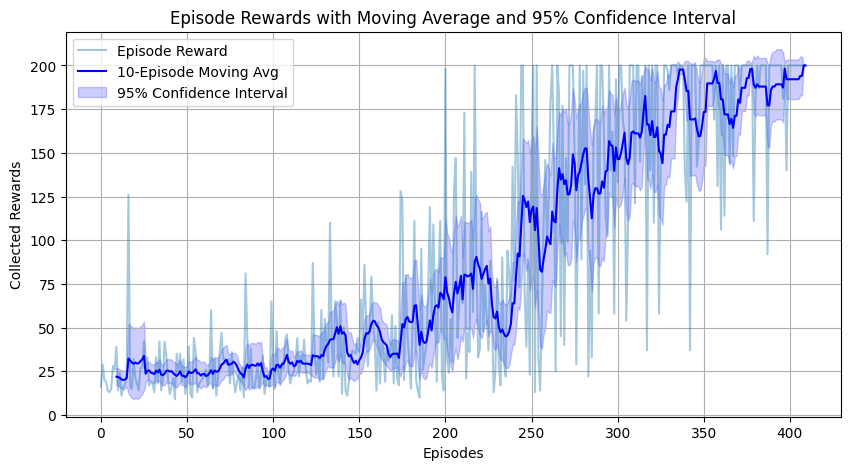

In [6]:
def plot_with_moving_average_and_ci(reward_history, window=10) : 
    reward_history = np.array(reward_history)
    episodes = np.arange(reward_history.shape[0])

    moving_avg = np.convolve(reward_history, np.ones(window) / window, mode='valid')

    rolling_std = np.array([
        reward_history[max(i - window + 1, 0):i + 1].std(ddof=0)
        for i in range(reward_history.shape[0])
    ])
    ci = 1.96 * rolling_std / np.sqrt(window)

    ma_episodes = np.arange(window - 1, reward_history.shape[0])

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, reward_history, label='Episode Reward', alpha=0.4)
    plt.plot(ma_episodes, moving_avg, label=f'{window}-Episode Moving Avg', color='blue')
    plt.fill_between(ma_episodes, moving_avg - ci[window-1:], moving_avg + ci[window-1:], alpha=0.2, label='95% Confidence Interval', color='blue')

    plt.xlabel('Episodes')
    plt.ylabel('Collected Rewards')
    plt.title('Episode Rewards with Moving Average and 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_with_moving_average_and_ci(episodes_reward_history)